### Estimating the number of EXE cells per time point
In this notebook, EXE cell numbers per age group are estimated by 

In [2]:
setwd(here::here())

In [122]:
getwd()

[1] "/net/mraid14/export/tgdata/users/markusm/exe-gastrulation"

In [216]:
library(anndata)
library(ggpubr)

In [208]:
library(metacell)
library(dplyr)
library(data.table)
library(tidyr)
library(ggplot2)
library(tgstat)

In [27]:
scdb_init('scrna_db/',force_reinit = T)
mat = scdb_mat('exe')
mc = scdb_mc('exe')
mat_emb = scdb_mat('emb')
mat_all = scdb_mat('embexe')
mc_all = scdb_mc('embexe_recolored')

initializing scdb to scrna_db/



In [8]:
df_embryo_rank = as.data.frame(fread('data/embexe.transcriptional_rank_developmental_time_with_age_group.tsv'))
head(df_embryo_rank)

,embryo,transcriptional_rank,embryo_nominal_time,morphological_stage,morphological_rank,developmental_time,age_group
,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<int>
1,EXE27_pooled,1,4.5,pre implantation,2,5.356873,1
2,EXE26_pooled,2,4.5,pre implantation,1,5.396876,1
3,EXE4_M2e2,3,NA,NA,NA,5.436775,2
4,EXE4_M2e1,4,5.5,pre cavitated/cavitated,8,5.476675,2
5,EXE4_M1e3,5,NA,NA,NA,5.516211,2
6,EXE4_M1e1,6,5.5,pre cavitated/cavitated,5,5.555747,2


In [9]:
df_embryo_experiment = unique(mat@cell_metadata[,c('embryo','Experiment')])
exe_embryos = df_embryo_experiment$embryo[ df_embryo_experiment$Experiment != 'Wildtype project']
placental_embryos = unique(mat_all@cell_metadata$embryo[mat_all@cell_metadata$embryo != mat_all@cell_metadata$embryo_with_placenta_information])
placental_embryos

[1] "EXE18_e1"   "EXE18_e2"   "EXE18_e4"   "EXE19_M1E2" "EXE19_M1E4"
 [6] "EXE19_M1E5" "EXE22_e1"   "EXE22_e5"   "EXE22_e2"   "EXE22_e3"  
[11] "EXE28_e1"   "EXE28_e3"   "EXE28_e2"

In [10]:
exe_embryos = intersect(exe_embryos,df_embryo_rank$embryo)
exe_embryos_f = setdiff(exe_embryos,placental_embryos)

In [11]:
embryonic_metacells = which(mc_all@colors %in% mc_all@color_key$color[1:38])
exe_metacells = which(mc_all@colors %in% mc_all@color_key$color[43:50])
embryonic_cells = names(mc_all@mc)[mc_all@mc %in% embryonic_metacells]
exe_cells = names(mc_all@mc)[mc_all@mc %in% exe_metacells]

In [12]:
df_cells = select(mat_all@cell_metadata,cell,Experiment,embryo)
df_cell_to_metacell = data.frame(cell = names(mc_all@mc),metacell = mc_all@mc)
df_metacell_color = data.frame(metacell = c(1:ncol(mc_all@e_gc)),color = mc_all@colors)
df_lineage_type = select(mc_all@color_key,'group','color')
df_lineage_type$lineage = c(rep('embryonic',38),rep('other',4),rep('exe',8),c('exe'))

df_metacell_color = df_metacell_color %>% left_join(df_lineage_type,by = 'color')
df_cell_to_metacell = df_cell_to_metacell %>% left_join(df_metacell_color,by = 'metacell')
df_cells = df_cells %>% left_join(df_cell_to_metacell,by = 'cell')
df_cells = df_cells %>% left_join(select(df_embryo_rank,embryo,transcriptional_rank),by = 'embryo')

In [13]:
df_cells_f = df_cells[!is.na(df_cells$lineage),]

In [14]:
df_embryo_cells_per_lineage = pivot_wider(data = count(df_cells_f,embryo,lineage),names_from = lineage,values_from = n)
df_plot = filter(df_embryo_cells_per_lineage,df_embryo_cells_per_lineage$embryo %in% exe_embryos)
df_plot = df_plot %>% left_join(df_embryo_rank,by = 'embryo')


In [15]:
table(mat@cell_metadata$time_bin)


   1    2    3    4    5    6 
 135  242  662  651 1214 1531 

In [17]:
df_embryo_time_bin = unique(select(mat@cell_metadata,embryo,time_bin,transcriptional_rank))
df_plot = df_plot %>% left_join(select(df_embryo_time_bin,embryo,time_bin))
df_plot$placenta_dissected_separately = ifelse(df_plot$embryo %in% placental_embryos,'yes','no')
df_plot$log_ratio_embryonic_exe = log2(df_plot$exe + 10) - log2(df_plot$embryonic + 10)
df_plot_f = filter(df_plot,df_plot$placenta_dissected_separately == 'no')

Joining, by = "embryo"


In [18]:
lin_regression_time_exe = lm(formula = log_ratio_embryonic_exe ~ developmental_time,data =df_plot_f)
lin_regression_time_exe$coefficients

slope_exe_vs_embryo_ratio = lin_regression_time_exe$coefficients[2]
intercept_exe_vs_embryo_ratio = lin_regression_time_exe$coefficients[1]


(Intercept) developmental_time 
          8.048542          -1.356193

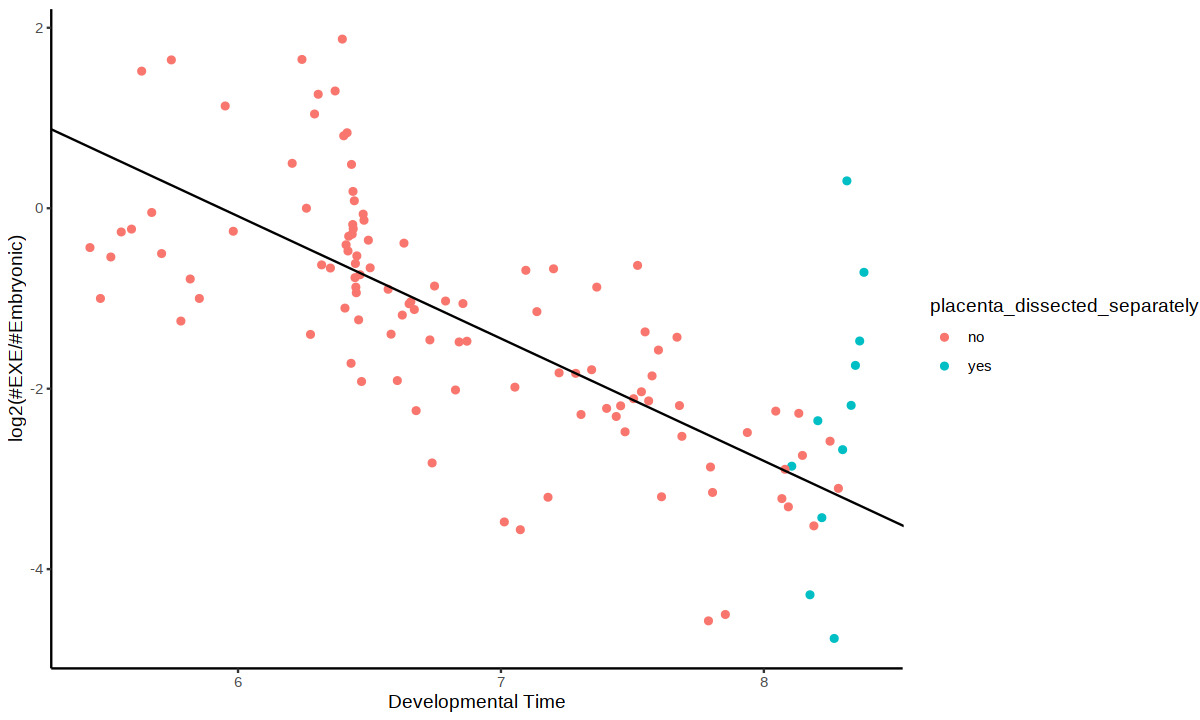

In [155]:
options(repr.plot.width=10, repr.plot.height=6)
p2 = ggplot(data = df_plot,aes(x = developmental_time,y = log2(exe + 10) - log2(embryonic + 10),color = placenta_dissected_separately)) +
    geom_point() + geom_abline(intercept = lin_regression_time_exe$coefficients[1],slope = lin_regression_time_exe$coefficients[2]) +
    ylab("log2(#EXE/#Embryonic)") + xlab('Developmental Time')
print(p2)


In [157]:
# load old cell count data
df_cell_count = fread('data/wt10.cell_counts.txt')
df_cell_count = df_cell_count %>% left_join(df_embryo_rank)
lin_regression_cell_count = lm(formula = log2(cell_count)~developmental_time,data = df_cell_count)
slope_cell_count = lin_regression_cell_count$coefficients[2]
intercept_cell_count = lin_regression_cell_count$coefficients[1]

Warning message in fread("data/wt10.cell_counts.txt"):
"Detected 2 column names but the data has 3 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."
Joining, by = "embryo"


In [158]:
df_cell_count

V1,embryo,cell_count,transcriptional_rank,embryo_nominal_time,morphological_stage,morphological_rank,developmental_time,age_group
<int>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<int>
1,190311_W_wt04,543,42,6.25,pre streak/early streak,44,6.390809,4
2,181209_R_3,1403,126,6.50,mid streak,116,6.721181,7
3,EXE5_E4,1734,80,6.50,early streak,98,6.479108,5
4,EXE2_e3,1439,149,7.00,late streak,135,7.053037,8
5,190307_W_wt10,2320,152,7.50,late streak,153,7.115545,9
6,EXE11_e1,1739,148,7.00,late streak,142,7.032716,8
7,191217_m2e2,1747,154,7.50,late streak,157,7.157906,9
8,EXE11_e1,1885,148,7.00,late streak,142,7.032716,8
9,EXE2_e3,1383,149,7.00,late streak,135,7.053037,8


In [159]:
# Calculate number of expected EXE cells as a function of time
# N_exe_expected = 2^(intercept_exe_cell_count + t*slope_exe_cell_count)

slope_exe_cell_count = lin_regression_time_exe$coefficients[2] + lin_regression_cell_count$coefficients[2]
intercept_exe_cell_count = lin_regression_time_exe$coefficients[1] + lin_regression_cell_count$coefficients[1]
slope_exe_cell_count
intercept_exe_cell_count


developmental_time 
          1.444412

(Intercept) 
  -0.718087

In [161]:
exe_embryos_time_bin = intersect(exe_embryos,df_embryo_time_bin$embryo[!is.na(df_embryo_time_bin$time_bin)])

In [162]:
f_embryo_selection = !is.na(df_cells$lineage) & df_cells$lineage == 'exe' & df_cells$embryo %in% exe_embryos_time_bin
exe_cell_type_vs_rank = table(df_cells$transcriptional_rank[f_embryo_selection],df_cells$group[f_embryo_selection])
exe_cell_type_vs_rank = exe_cell_type_vs_rank[,rev(mc@color_key$group)]

In [163]:
dim(exe_cell_type_vs_rank)

[1] 83  9

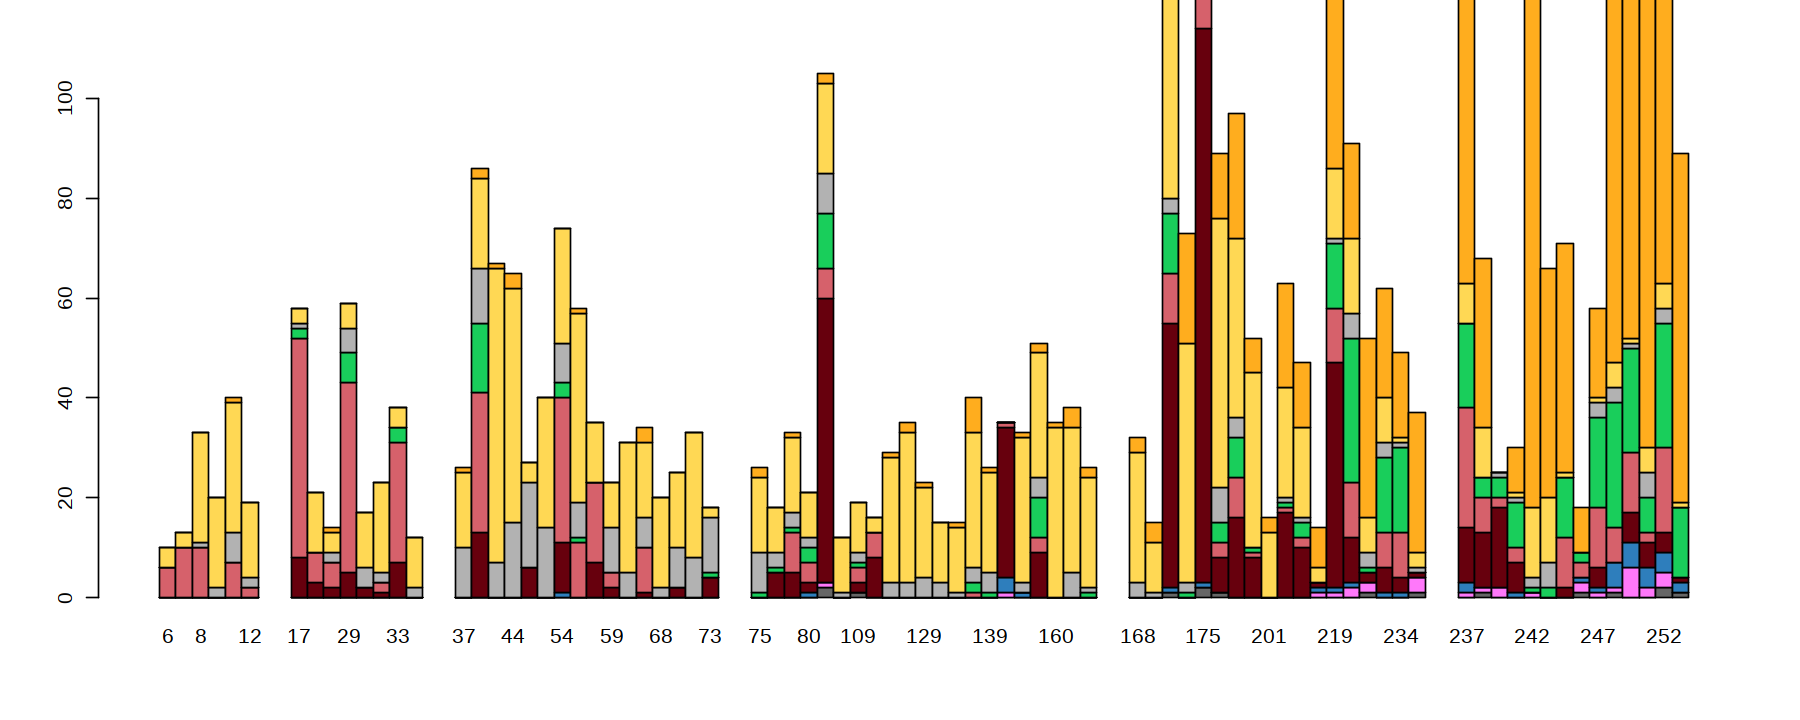

In [164]:
options(repr.plot.width=15, repr.plot.height=6)
cell_type_to_color = mc_all@color_key$color
names(cell_type_to_color) = mc_all@color_key$group

f_not_na = !is.na(df_embryo_time_bin$time_bin)
rank_to_time_bin = as.numeric(as.character(df_embryo_time_bin$time_bin[f_not_na]))
names(rank_to_time_bin) = df_embryo_time_bin$transcriptional_rank[f_not_na]


space_in_between = diff(rank_to_time_bin[rownames(exe_cell_type_vs_rank)])
space_in_between = c(0,space_in_between)
barplot(t(exe_cell_type_vs_rank),col = cell_type_to_color[colnames(exe_cell_type_vs_rank)],ylim = c(0,100),
        space = 2*space_in_between)

In [165]:
# Expected number of EXE cells at E7.5
message("Expected number of EXE cells at E7.5: ", round(2^(intercept_exe_cell_count + slope_exe_cell_count*7.5)))
message("Expected number of embryonic cells at E7.5: ", round(2^(intercept_cell_count + slope_cell_count*7.5)))

        

Expected number of EXE cells at E7.5: 1109

Expected number of embryonic cells at E7.5: 4830



### Extended Data Figure 2d
Calculate sampled number of cells per time bin and expected number of cells per time bin

In [173]:
exe_cells_per_time_bin

time_bin,exe_cells_per_time_bin,developmental_time,exe_expected_number
<fct>,<int>,<dbl>,<dbl>
1,135,5.664127,176.4659
2,242,6.194534,300.1152
3,662,6.423485,377.4317
4,651,6.800285,550.3959
5,1214,7.770392,1453.7478
6,1531,8.256998,2366.3044


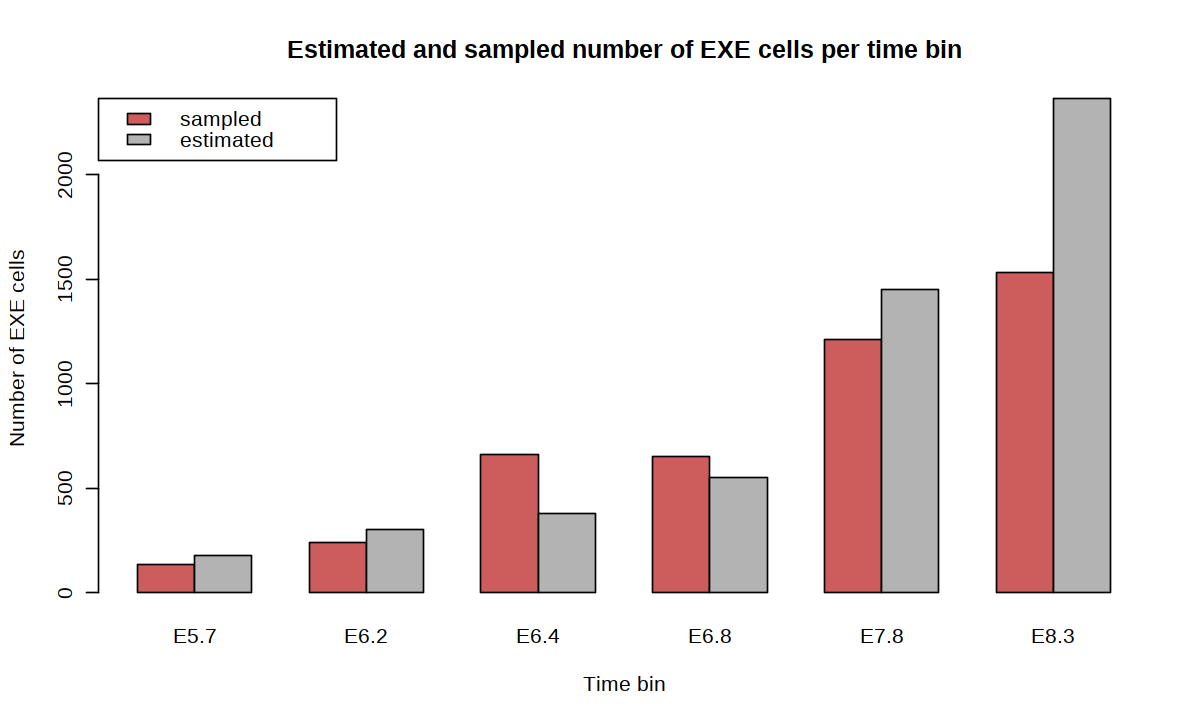

In [192]:
options(repr.plot.width=10, repr.plot.height=6)
exe_cells_per_time_bin = df_plot %>% group_by(time_bin) %>% summarise(exe_cells_per_time_bin = sum(exe),developmental_time = mean(developmental_time))
exe_cells_per_time_bin = exe_cells_per_time_bin[!is.na(exe_cells_per_time_bin$time_bin),]
exe_cells_per_time_bin$exe_expected_number = 2^(intercept_exe_cell_count + slope_exe_cell_count*exe_cells_per_time_bin$developmental_time)


time_bin_labels = paste0("E",round(exe_cells_per_time_bin$developmental_time,1))

barplot(rbind(exe_cells_per_time_bin$exe_cells_per_time_bin,exe_cells_per_time_bin$exe_expected_number),
        legend.text = c("sampled","estimated"),args.legend = list(x = "topleft"),
        names.arg = time_bin_labels,
        xlab = "Time bin",ylab = "Number of EXE cells",
        main = "Estimated and sampled number of EXE cells per time bin",beside = T,col = c('indianred','gray70'))

